In [1]:
import requests
import lxml.html as lh
import progressbar

In [2]:
import os.path
import urllib
import zipfile
import glob
import operator

In [3]:
import glob
import pandas as pd

In [4]:
pd.set_option('display.max_columns',200)

# Setup GDELT Download

In [5]:
gdelt_base_url = 'http://data.gdeltproject.org/events/'

# get the list of all the links on the gdelt file page
page = requests.get(gdelt_base_url+'index.html')
doc = lh.fromstring(page.content)
link_list = doc.xpath("//*/ul/li/a/@href")

# separate out those links that begin with four digits 
vec_files_download = [x for x in link_list if str.isdigit(x[0:4])]
print(len(vec_files_download))

3464


# Download GDELT Files

In [6]:
colnames = pd.read_excel('./gdelt_csv_colnames.xlsx',sheet_name='Sheet1',index_col='Column ID')['Field Name']

In [7]:
%%time
file_cnt = 0
file_limit = 100
file_local_path = './tmp/'
df_list = []
vec_files_completed = []

viz_bar = progressbar.ProgressBar(max_value=len(vec_files_download)).start()
for i,compressed_file in enumerate(vec_files_download):
    # if we dont have the compressed file stored locally, go get it. Keep trying if necessary.
    while not os.path.isfile(file_local_path+compressed_file): 
        urllib.request.urlretrieve(url=gdelt_base_url+compressed_file,filename=file_local_path+compressed_file)
        
    # extract the contents of the compressed file to a temporary directory    
    z = zipfile.ZipFile(file=file_local_path+compressed_file, mode='r')    
    z.extractall(path=file_local_path)
    os.remove(file_local_path+compressed_file)
    
    # build dataframe of contents
    tmp_df = []
    vec_files_csvs = glob.glob(file_local_path+'*')
    for j,active_file in enumerate(vec_files_csvs):
        tmp_df.append(pd.read_csv(active_file,sep='\t',header=None,dtype=str,names=colnames,index_col=['GLOBALEVENTID']))
        vec_files_completed.append(active_file)

    # once everything is safely stored away, remove the temporary files
    for active_file in vec_files_csvs:
        os.remove(active_file)
    
    # build pivot tables, store those and delete temporary files
    tmp_df = pd.concat(tmp_df,ignore_index=True,sort=False)
    tmp_df = tmp_df.loc[~(tmp_df['EventCode']=='---')].copy()
    tmp_df['EventCode'] = tmp_df['EventCode'].astype(int)
    tmp_pivot = tmp_df.pivot_table(index=['SQLDATE','MonthYear','EventCode'],values='SOURCEURL',aggfunc=len,fill_value=0).reset_index()
    tmp_pivot.columns = ['SQLDATE','MonthYear','EventCode','cnt']
    df_list.append(tmp_pivot)
    
    file_cnt += 1
    viz_bar.update(i+1)
    if(file_cnt>=file_limit):
        break

  2% (100 of 3464) |                     | Elapsed Time: 0:04:19 ETA:   2:10:18

CPU times: user 2min 54s, sys: 26.9 s, total: 3min 21s
Wall time: 4min 19s


In [8]:
len(vec_files_completed)

100

In [9]:
df = pd.concat(df_list,ignore_index=True,sort=False)
print(df.shape)
df.head()

(47817, 4)


,SQLDATE,MonthYear,EventCode,cnt
0,20120608,201206,13,4
1,20120608,201206,20,2
2,20120608,201206,42,2
3,20120608,201206,43,2
4,20120608,201206,110,1


# Incorporate Event Codes

In [10]:
df_event_codes = pd.read_csv('./gdelt_event_codes.csv',sep=':',header=None)
df_event_codes.columns = ['event_code','desc']
df_event_codes['desc'] = df_event_codes['desc'].str.strip()
df_event_codes['desc'] = df_event_codes['desc'].str.title()
df_event_codes['event_code_str'] = df_event_codes['event_code'].astype(str)
print(df_event_codes.shape)
df_event_codes.drop_duplicates(subset=['event_code'],inplace=True)
print(df_event_codes.shape)
df_event_codes.head()

(316, 3)
(305, 3)


,event_code,desc,event_code_str
0,1,Make Public Statement,1
1,10,"Make Statement, Not Specified Below",10
2,11,Decline Comment,11
3,12,Make Pessimistic Comment,12
4,13,Make Optimistic Comment,13


In [11]:
vec_ecs_military = df_event_codes.loc[df_event_codes['desc'].str.contains('military',case=False)]['event_code'].tolist()
print(len(vec_ecs_military))

vec_ecs_nuclear = df_event_codes.loc[df_event_codes['desc'].str.contains('nuclear',case=False)]['event_code'].tolist()
print(len(vec_ecs_nuclear))

vec_ecs_weapons = df_event_codes.loc[df_event_codes['desc'].str.contains('weapon',case=False)]['event_code'].tolist()
print(len(vec_ecs_weapons))

vec_ecs_protest = df_event_codes.loc[df_event_codes['event_code_str'].str.startswith('14')]['event_code'].tolist()
print(len(vec_ecs_protest))

26
1
5
27


In [12]:
df_events = pd.merge(left=df,right=df_event_codes,left_on='EventCode',right_on='event_code',how='left')
print(df_events.shape)
df_events.head()

(47817, 7)


,SQLDATE,MonthYear,EventCode,cnt,event_code,desc,event_code_str
0,20120608,201206,13,4,13.0,Make Optimistic Comment,13
1,20120608,201206,20,2,20.0,"Make An Appeal Or Request, Not Specified Below",20
2,20120608,201206,42,2,42.0,Make A Visit,42
3,20120608,201206,43,2,43.0,Host A Visit,43
4,20120608,201206,110,1,110.0,"Disapprove, Not Specified Below",110


# Build Subsets of Interest

In [13]:
df_events.loc[df_events['event_code'].isin(vec_ecs_military),'ec_category'] = 'military'
df_events.loc[df_events['event_code'].isin(vec_ecs_nuclear),'ec_category'] = 'nuclear'
df_events.loc[df_events['event_code'].isin(vec_ecs_weapons),'ec_category'] = 'weapons'
df_events.loc[df_events['event_code'].isin(vec_ecs_protest),'ec_category'] = 'protest'

In [14]:
df_events['ec_category'].value_counts()

military    3288
protest     1922
weapons      736
Name: ec_category, dtype: int64

# Plots

In [15]:
df_events_pivot = df_events.pivot_table(index='SQLDATE',columns='ec_category',values='cnt',aggfunc=sum,fill_value=0)
print(df_events_pivot.shape)
df_events_pivot.head()

(288, 3)


ec_category,military,protest,weapons
SQLDATE,,,
20120306,1,0,0
20120307,2,0,0
20120308,2,0,0
20120309,3,0,0
20120310,2,0,0


In [16]:
val_fig_size = (14,10)

<AxesSubplot:xlabel='SQLDATE'>

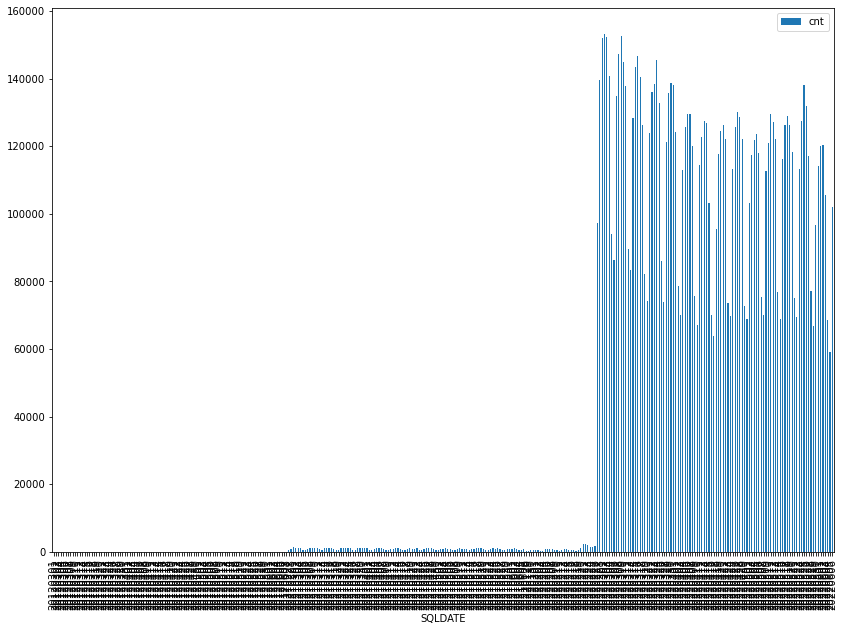

In [18]:
df_events_pivot_dates = df_events.pivot_table(index='SQLDATE',values='cnt',aggfunc=sum,fill_value=0).reset_index()
df_events_pivot_dates.plot.bar(x='SQLDATE',y='cnt',figsize=val_fig_size)

In [19]:
print(df_events_pivot_dates['SQLDATE'].astype(int).quantile(q=0.5))

20210503.0


In [20]:
vec_indices = [int(x)>df_events_pivot_dates['SQLDATE'].astype(int).quantile(q=0.5) for x in df_events_pivot.index]
#df_events_pivot_subset = df_events_pivot.loc[df_events_pivot.index.str.contains('2022')].copy()
df_events_pivot_subset = df_events_pivot.loc[vec_indices].copy()
df_events_pivot_subset.head()

ec_category,military,protest,weapons
SQLDATE,,,
20210504,56,9,13
20210505,55,17,10
20210506,43,7,19
20210507,6,8,8
20210508,28,7,11


<AxesSubplot:xlabel='SQLDATE'>

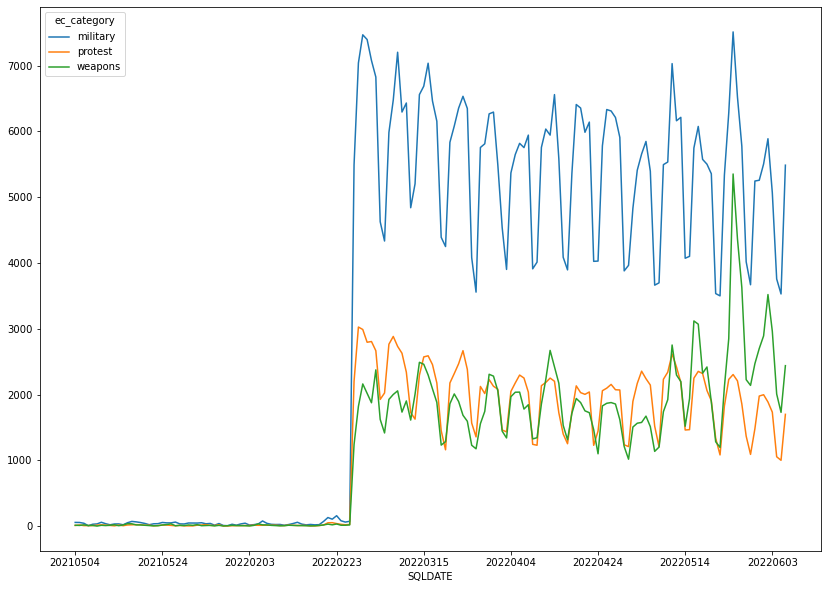

In [21]:
df_events_pivot_subset.plot.line(figsize=val_fig_size)

<AxesSubplot:xlabel='SQLDATE'>

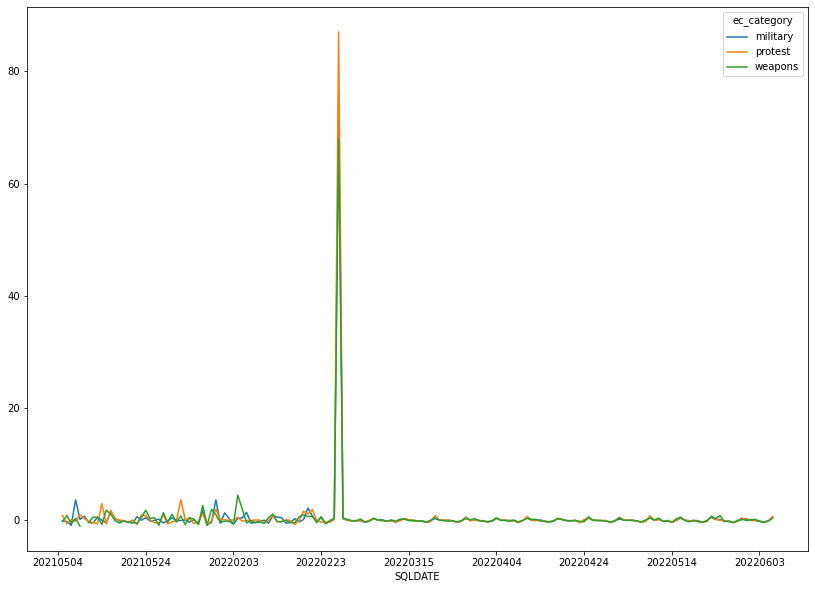

In [22]:
df_events_pivot_subset.pct_change().plot(figsize=val_fig_size)

# Export

In [ ]:
# write output somewhere...